In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [127]:
#we can verify this looking to the images on 'data' directory
IMG_SIZE = 256

#size of the batches of data
BATCH_SIZE = 32

#refers to rgb
CHANNELS = 3

#nº of epochs to training process
EPOCHS = 50

# 1. Data Collection

In [130]:
#loading data
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/PlantVillage",
    shuffle=True,
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [131]:
tf.convert_to_tensor((2,2))

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([2, 2])>

In [132]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

These class names are inferred because of the way we imported our data. Using this function to load data, it expects that our directory is subdvided into subdirectories, which contains the images of each class.

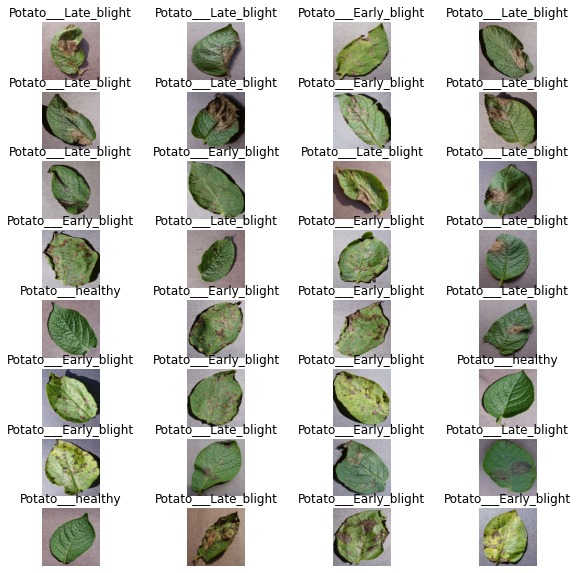

In [212]:
#visualizing some images
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(32):
        ax = plt.subplot(8,4,(i+1))
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

# 2. Data cleaning & preprocessing

### 2.1 Split the data

In [134]:
#function to split the data on training, test and validation sets
def split_data(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(dataset)
    
    if shuffle:
        dataset.shuffle(shuffle_size, seed=2022)
    
    train_size = int(ds_size * train_split)
    test_size = int(ds_size * val_split)
    
    train_ds = dataset.take(train_size)
    test_ds = dataset.skip(train_size).take(test_size)
    val_ds = dataset.skip(train_size).skip(test_size)
    
    return train_ds, test_ds, val_ds

In [135]:
#getting training, testing and validation datasets
train, test, val = split_data(dataset)

#getting their sizes to check if everything was correct
len(train), len(test), len(val)

(54, 6, 8)

It's right because our number of batches is 68, so it's divided on the proper way.

### 2.2 Shuffle, Cache and Prefetch

In [136]:
train = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val = val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Reference to understand that stuff: https://www.tensorflow.org/guide/data_performance

### 2.3 Resizing and Scaling data

In [137]:
resize_and_rescale = tf.keras.Sequential([
    #resize image in case it comes in the wrong format
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    
    #rescale image pixels to be between 0 and 1
    layers.Rescaling(scale=1./255)
])

### 2.4 Data Augmentation

It's the process of providing more examples to our model. During the training process, we modify our images to give more examples to our models, so, for example, we rotate the images, add contrast to it, zoom etc... The image below provides an better idea of this process.

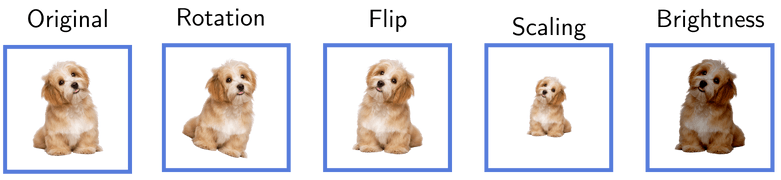

In [138]:
data_augmentation = tf.keras.Sequential([
    #flip image
    layers.RandomFlip("horizontal_and_vertical"),
    
    #rotate image
    layers.RandomRotation(0.2)
])

# 3. Model Building

### 3.1 Architecture of the Convolutional Neural Network (CNN)

In [170]:
input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [171]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_20 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_66 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_66 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_67 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_67 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_68 (Conv2D)          (32, 60, 60, 64)        

### 3.2 Setting training parameters

In [173]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

### 3.2 Training and evaluating

In [175]:
history = model.fit(
    train,
    batch_size=BATCH_SIZE,
    validation_data=test,
    verbose=1,
    epochs=20,
)

Epoch 1/20
54/54 [==============================] - 61s 1s/step - loss: 0.8738 - accuracy: 0.5330 - val_loss: 0.7902 - val_accuracy: 0.5417
Epoch 2/20
54/54 [==============================] - 60s 1s/step - loss: 0.7513 - accuracy: 0.6273 - val_loss: 0.8230 - val_accuracy: 0.5052
Epoch 3/20
54/54 [==============================] - 59s 1s/step - loss: 0.6809 - accuracy: 0.6852 - val_loss: 0.4775 - val_accuracy: 0.7812
Epoch 4/20
54/54 [==============================] - 58s 1s/step - loss: 0.5037 - accuracy: 0.7691 - val_loss: 0.3955 - val_accuracy: 0.8385
Epoch 5/20
54/54 [==============================] - 59s 1s/step - loss: 0.3865 - accuracy: 0.8356 - val_loss: 0.3598 - val_accuracy: 0.8490
Epoch 6/20
54/54 [==============================] - 59s 1s/step - loss: 0.4012 - accuracy: 0.8443 - val_loss: 0.2975 - val_accuracy: 0.8906
Epoch 7/20
54/54 [==============================] - 59s 1s/step - loss: 0.2792 - accuracy: 0.8924 - val_loss: 0.3288 - val_accuracy: 0.8698
Epoch 8/20
54/54 [==

In [176]:
scores = model.evaluate(val)
print("Loss:", scores[0])
print("Accuracy:", scores[1])

8/8 [==============================] - 3s 197ms/step - loss: 0.1966 - accuracy: 0.9353
Loss: 0.19655174016952515
Accuracy: 0.9353448152542114


### 3.3 Analysing accuracy and loss

In [177]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [178]:
train_acc = history.history["accuracy"]
test_acc = history.history["val_accuracy"]
train_loss = history.history["loss"]
test_loss = history.history["val_loss"]

#### 3.3.1 Training Accuracy vs. Training Loss

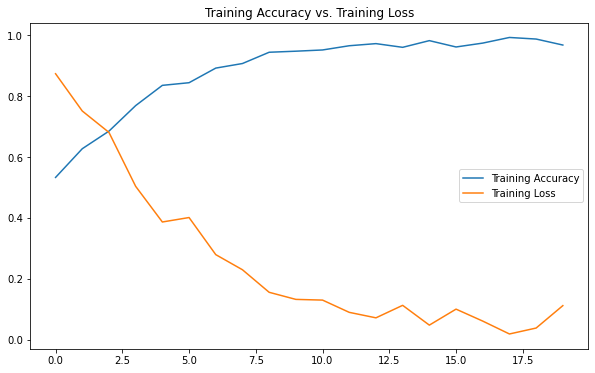

In [182]:
plt.figure(figsize=(10, 6))
plt.plot(range(20), train_acc, label='Training Accuracy')
plt.plot(range(20), train_loss, label='Training Loss')
plt.legend(loc='center right')
plt.title('Training Accuracy vs. Training Loss')
plt.show()

#### 3.3.2 Training Accuracy and Test Accuracy

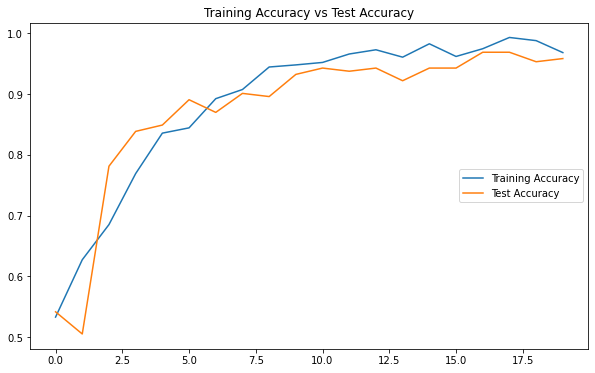

In [183]:
plt.figure(figsize=(10, 6))
plt.plot(range(20), train_acc, label='Training Accuracy')
plt.plot(range(20), test_acc, label='Test Accuracy')
plt.legend(loc='center right')
plt.title('Training Accuracy vs Test Accuracy')
plt.show()

#### 3.3.3 Training Loss and Test Loss

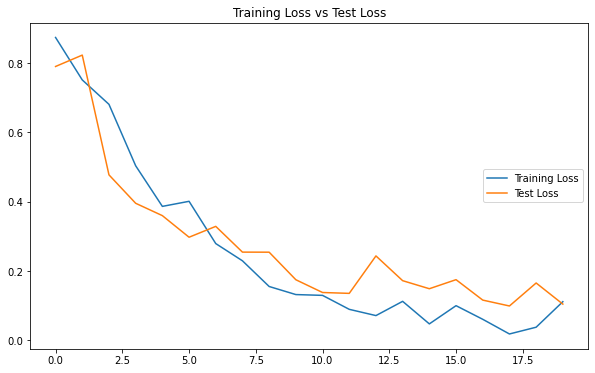

In [184]:
plt.figure(figsize=(10, 6))
plt.plot(range(20), train_loss, label='Training Loss')
plt.plot(range(20), test_loss, label='Test Loss')
plt.legend(loc='center right')
plt.title('Training Loss vs Test Loss')
plt.show()

### 3.4 Making predictions

In [268]:
def make_prediction(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    
    prediction = model.predict(img_array, verbose=0)
    
    predicted_class = class_names[np.argmax(prediction)]
    confidence = round(100*np.max(prediction), 2)
    
    return predicted_class, confidence

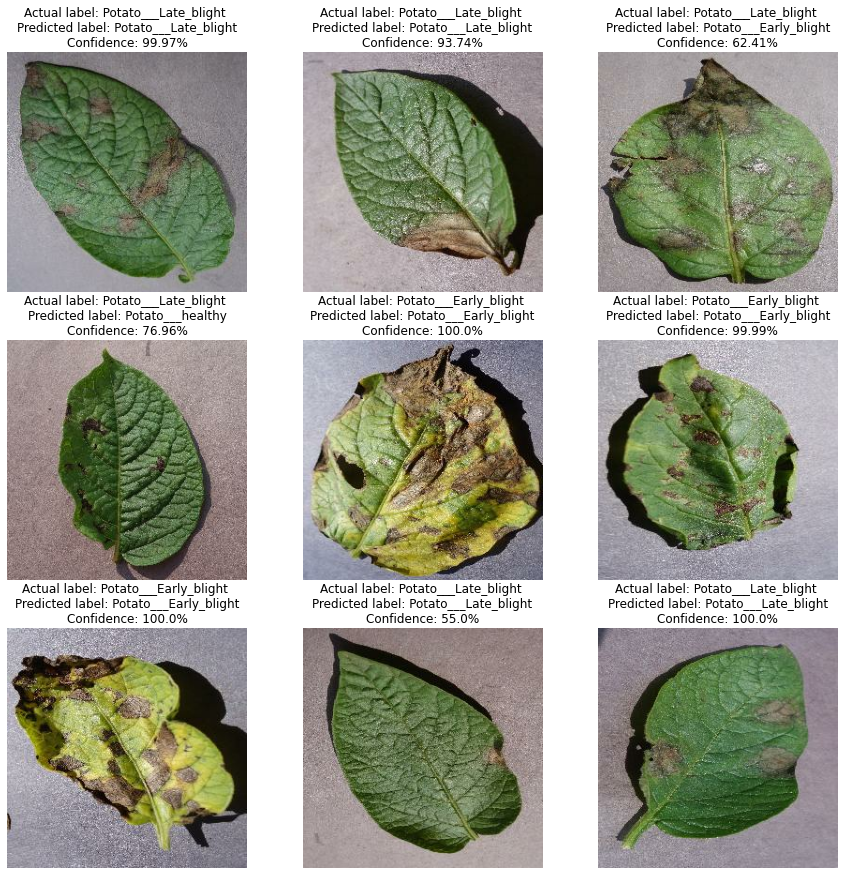

In [270]:
plt.figure(figsize=(15,15))
for img_batch, label_batch in val.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        
        #getting image and label image
        img = img_batch[i].numpy().astype("uint8")
        real_label = class_names[label_batch[i]]
        
        #plotting image
        plt.imshow(img)
        
        #getting rid of axis
        plt.axis("off")
        
        #making prediction
        predicted_class, confidence = make_prediction(model, img)
        
        #displaying prediction, actual label and confidence
        plt.title(f"Actual label: {real_label} \nPredicted label: {predicted_class}\nConfidence: {confidence}%")

# 4. Saving the trained model

In [271]:
model_version=1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [2]:
new_model = tf.keras.models.load_model('../models/1')

In [3]:
new_model.save(f"../models/model.h5")